# Bostrom Simulation
---

In [1]:
import time
import itertools

# Standard libraries: https://docs.python.org/3/library/
import math

# Analysis and plotting modules
import pandas as pd
import matplotlib.pyplot as plt

# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

from collections import Counter
from cadCAD import configs

# custom functions modules
from utils.partial_state_update_blocks import partial_state_update_blocks
# from utils.plots import df_preparator, boot_supply_plot
from utils.plots import *

## Initial state

In [2]:
sim_period = 10           # amount of years for simulating
timesteps_per_year = 365        # units per year(days`

In [3]:
initial_state = {
    'boot_inflation_rate': 0.10,
    'boot_supply': 1_000_000_000_000_000,
    'boot_liquid_supply': 290_000_000_000_000,
    'boot_frozen_supply': 700_000_000_000_000,
    'boot_bonded_supply': 10_000_000_000_000,
    'boot_claimed_supply': 0,
    'boot_to_distribution_supply': 0,
    'hydrogen_supply': 10_000_000_000_000,
    'agents_count': 250,
    'capitalization_per_agent': 15,
    'capitalization_in_eth': 250 * 15,
    'cyberlinks_per_day': 250 * 15 / 1_000_000,
    'validator_revenue_gboot': 0.3,
    'timestep_provision_boot': 0,
    'gboot_price': 250 * 1 / 1_000_000,
    'cyberlinks_count': 0,
    'ampere_supply': 0,
    'volt_supply': 0,
    'investmint_max_period': 90,
    'ampere_mint_rate': 1,
    'volt_mint_rate': 1,
    'gpu_memory_usage': 0,
    'ampere_volt_ratio': 1,
    'volt_liquid_supply': 0,
    'ampere_liquid_supply': 0
}

## Params for simulating

In [4]:
# vesting_speed = [3, 6, 12, 18, 24, 30, 36]
# unvesting_speed = [72, 60, 48, 36, 30, 24]

# parameter_sweep = list(itertools.product(vesting_speed, unvesting_speed))

# vesting_speed = [x[0] for x in parameter_sweep]
# unvesting_speed = [x[1] for x in parameter_sweep]

In [5]:
system_params = {
    # timesteps params
    'timesteps_per_year': [timesteps_per_year], # units per year(days)
    
    # boot inflation params
    'boot_inflation_rate_change_annual': [0.07], # maximum inflation rate change per year
    'boot_inflation_rate_min': [0.05], # minimum percent of the inflation
    'boot_inflation_rate_max': [0.20], # maximum percent of the inflation
    'boot_bonded_share_target': [0.70], # desireable ratio between vested tokens and tokens supply
    
    # boot bonding amount params
    'boot_bonding_share': [0.70],
    
    # gift claim dynamics params
    'days_for_gift_activation': [30],
    'claimed_at_activation_share': [0.85],
    'days_for_gift_full_claim': [150],
    'boot_gift_amount_init': [700_000_000_000_000],
    'liquid_boot_supply_share': [0.25],
    
    # understanding network effects params
    'agents_count_at_activation': [10_000],
    'start_capitalization_per_agent': [1],
    'capitalization_per_agent': [1],
    
    # predicting volts demand params
    'cyberlinks_transactions_coeff': [15],
    'extra_links': [0],
    'guaranteed_links': [0],
    
    # amper and volt minting params
    'ampere_base_halving_period': [365 * 3 / 2],
    'volt_base_halving_period': [365 * 3 / 2],
    'ampere_mint_rate_init': [1], # initial mint rate for Amperes
    'volt_mint_rate_init': [1], # initial mint rate for Voltes
    'ampere_base_investmint_amount': [1_000_000_000], # initial cost for resource token in 1 cycle
    'volt_base_investmint_amount': [1_000_000_000], # initial cost for resource token in 1 cycle
    'ampere_base_investmint_period': [30],
    'volt_base_investmint_period': [30],
    'investmint_max_period_init': [120],
    'horizont_period_init': [365],
    
    # Investments into infrastructure params
    'validator_commission': [0.1],
    'max_validator_count': [92],
}

In [6]:
del configs[:]
experiment = Experiment()

sim_config = config_sim({
    'N': 1,
    'T': range(int(math.ceil(sim_period * timesteps_per_year))),
    'M': system_params
})

experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

In [7]:
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (3650, 29, 1, 25)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.94s


In [8]:
start_time = time.time()
simulation_result = pd.DataFrame(raw_result)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0512089729309082 seconds ---


In [9]:
start_time = time.time()

In [10]:
df = simulation_result.copy()

In [11]:
# save local model file for power bi
# import pyarrow as pa
# import pyarrow.parquet as pq
# table = pa.Table.from_pandas(df)
# pq.write_table(table, 'simulation.parquet')

In [12]:
plot_df = df_preparator(df)

## Boot suplly and inflation

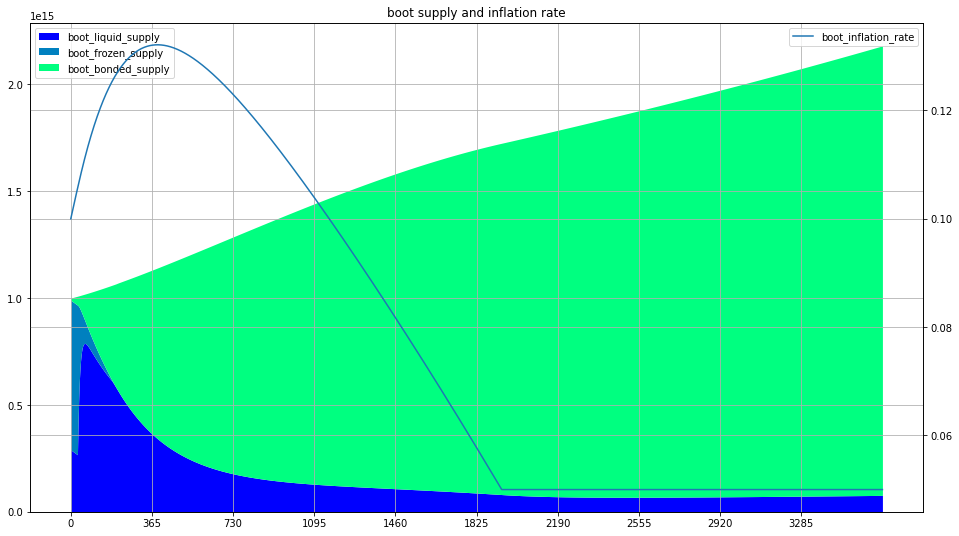

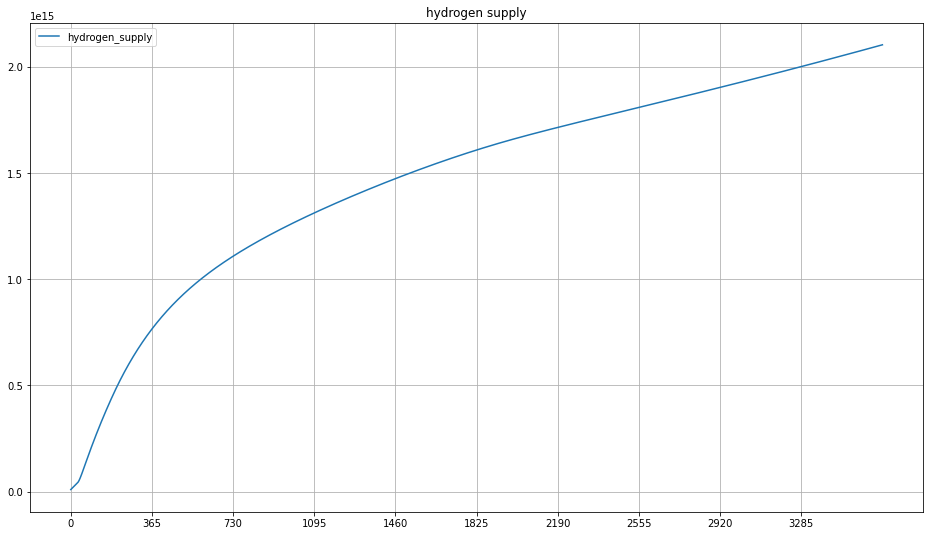

In [24]:
boot_supply_plot(plot_df)
hydrogen_supply_plot(plot_df)

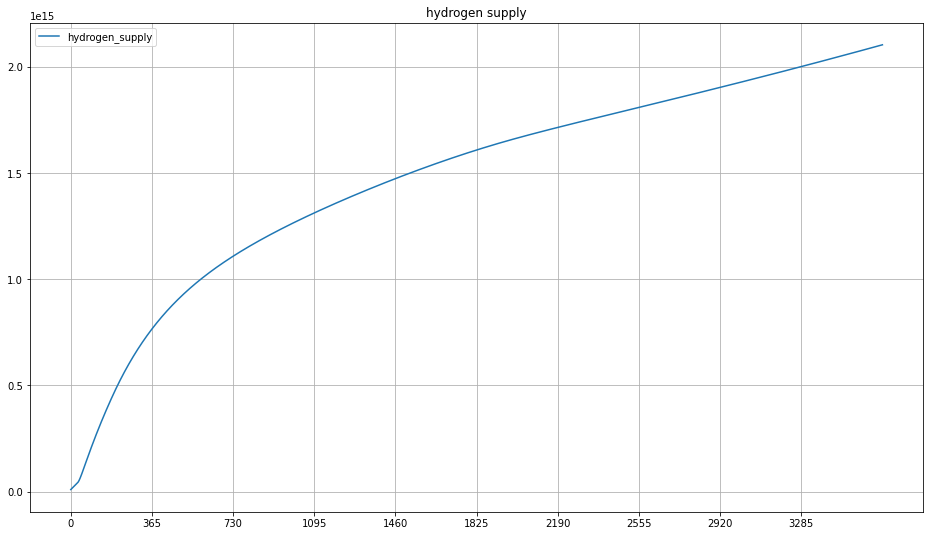

In [14]:
hydrogen_supply_plot(plot_df)

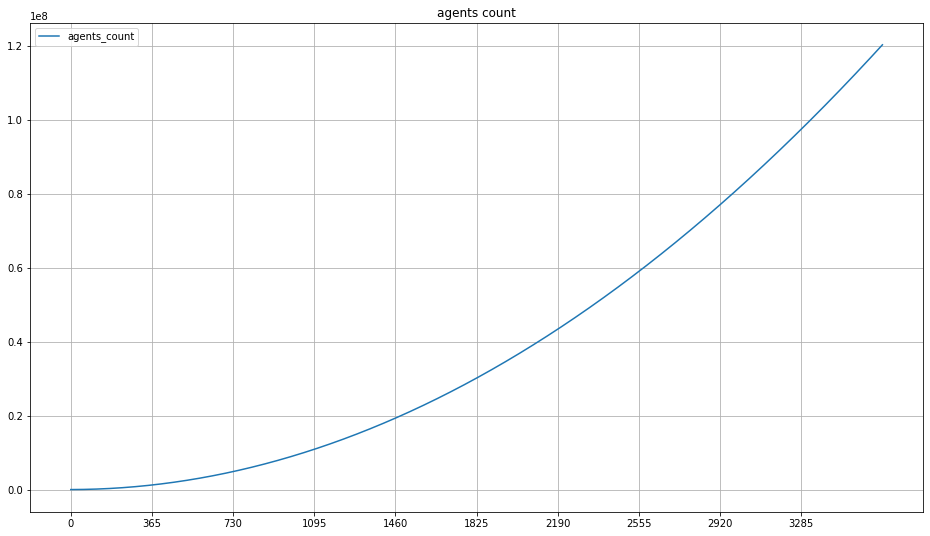

In [15]:
agents_count_plot(plot_df)

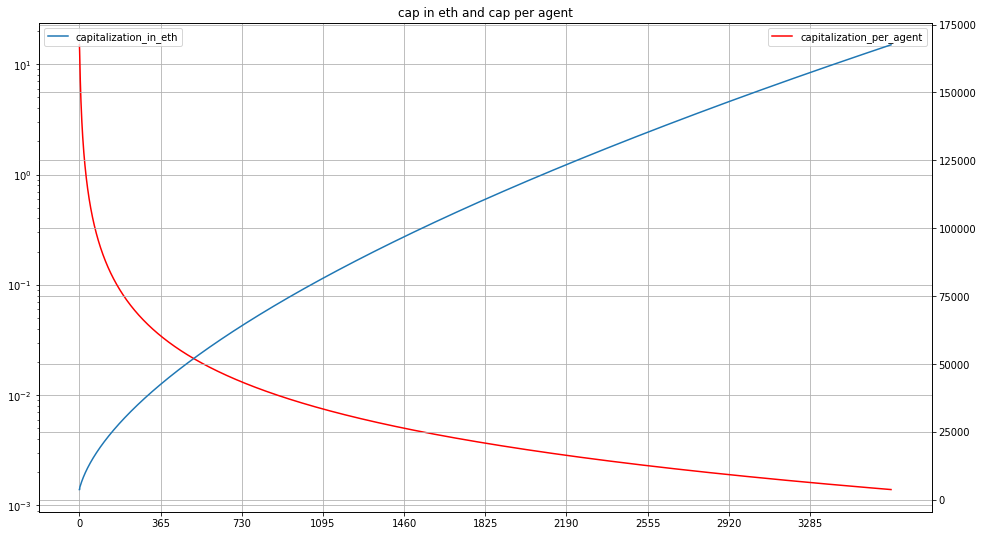

In [16]:
capitalization_plot(plot_df)

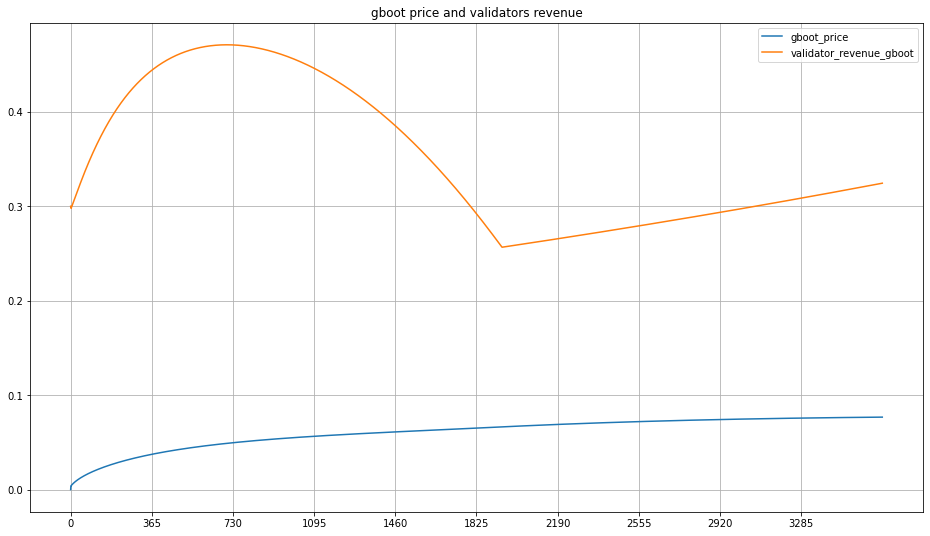

In [17]:
gboot_price_plot(plot_df)

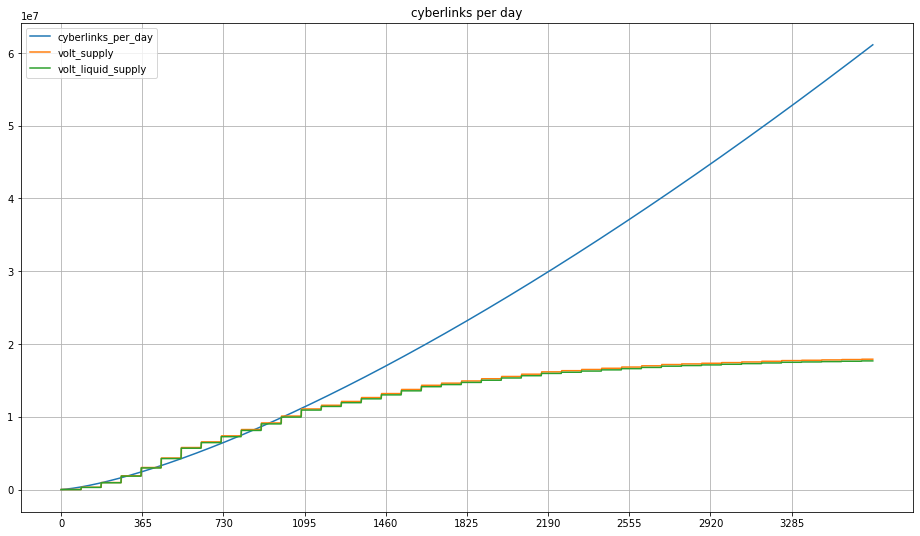

In [18]:
cyberlinks_per_day_plot(plot_df)

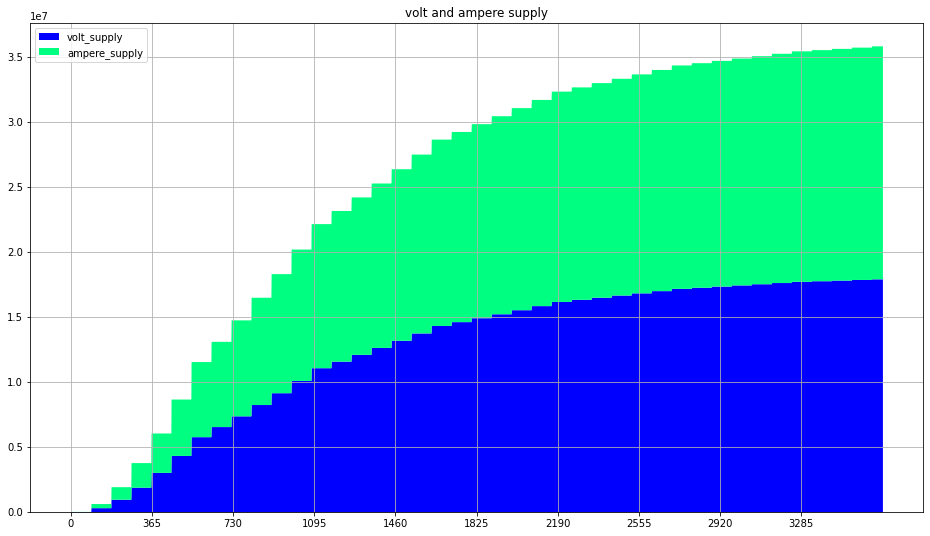

In [19]:
volt_and_ampere_supply_plot(plot_df)

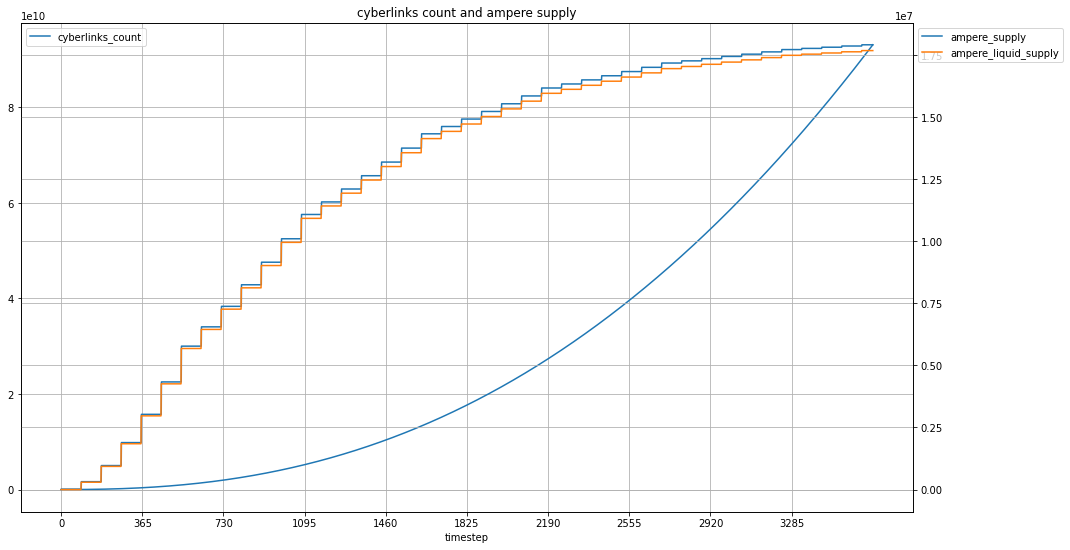

In [20]:
cyberlinks_count_plot(plot_df)

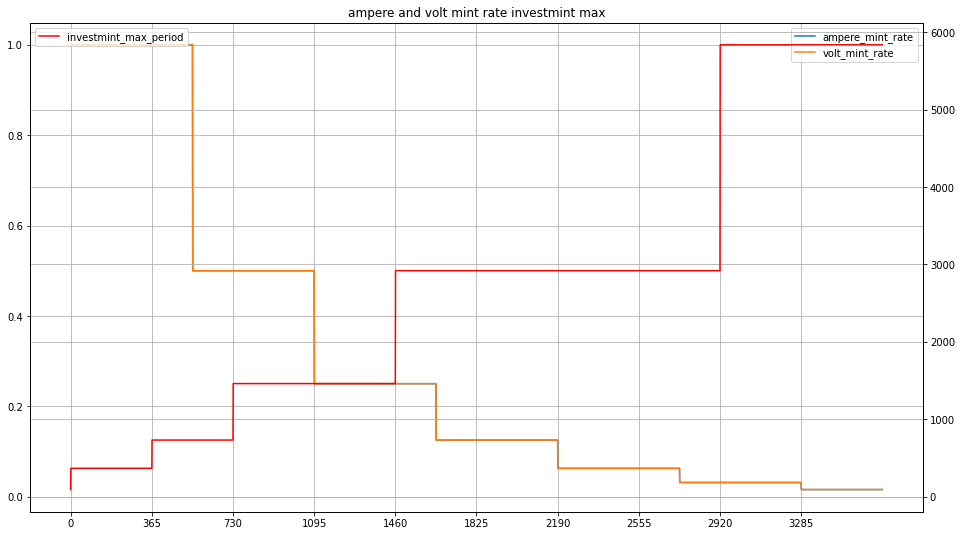

In [21]:
mint_rate_plot(plot_df)

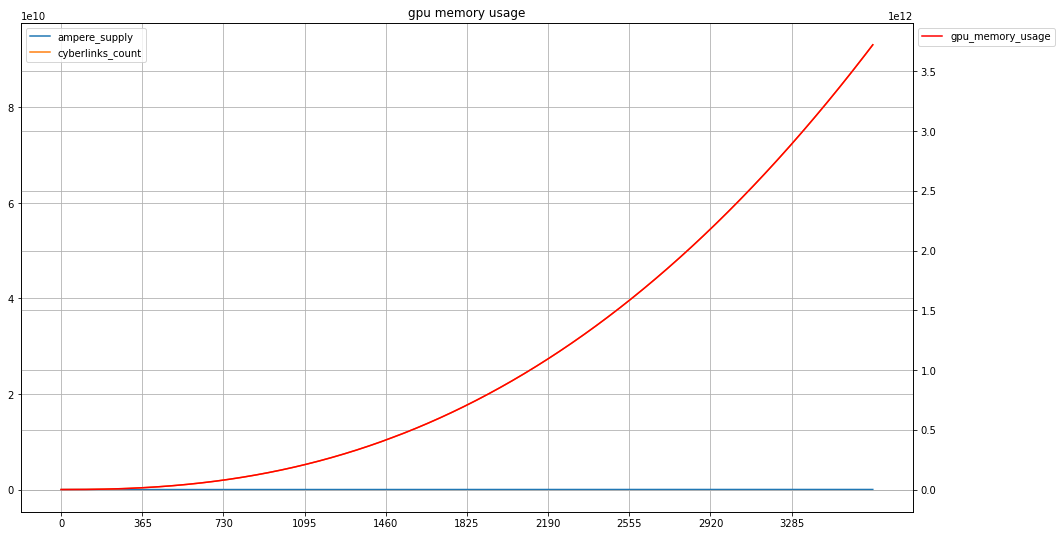

In [22]:
gpu_memory_usage_plot(plot_df)

In [23]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 61.785212993621826 seconds ---
